In [328]:
# Unlike the previous script (MITLL_RNN_DataFile_Future), this script do not consider only the encounters with conflict for data prepartion. 
# This script generates data where class 1 is oversampled by adding different noise realizations to the truth.


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab
import string
import math


In [329]:
!pip install pymap3d

In [330]:
import pymap3d as pm

In [331]:
pi = math.pi

In [332]:
import os
arr = os.listdir('F:\SBIR-2020\RNN-Classification-Papers\DataSets\RNN_Data_Classification')


In [333]:
arr[0:11]

['.ipynb_checkpoints',
 'MITLL_RNN_DataFile-Future-Draf2.ipynb',
 'MITLL_RNN_DataFile-Future-Draft1.ipynb',
 'MITLL_RNN_DataFile-Future-Draft3.ipynb',
 'MITLL_RNN_DataFile-Future.ipynb',
 'MITLL_RNN_DataFile.ipynb',
 'MITLL_RNN_DataFile_Future_New.ipynb',
 'MITLL_RNN_DataFile_Future_TestDataPlotting - Copy.ipynb',
 'MITLL_RNN_DataFile_Future_TestDataPlotting.ipynb',
 'MITLL_RNN_Data_OversampleClass1.ipynb',
 'truth_mit_ll_10003.txt']

In [334]:
arr[10]

'truth_mit_ll_10003.txt'

In [335]:
D_files = 10

In [336]:
N_encounter_file = len(arr) - D_files
N_encounter_file

10000

In [337]:
### FUNCTIONS for velocity rotation

def enu2ecefRotation(lat, lon):
    
    cosLat = np.cos(lat) 
    sinLat = np.sin(lat)
    cosLon = np.cos(lon)
    sinLon = np.sin(lon)
    
    TT = np.array([[-sinLon , -sinLat*cosLon, cosLat*cosLon],
                   [cosLon, -sinLat*sinLon, cosLat*sinLon],
                   [0.0, cosLat, sinLat]])
    
    return TT
    
    
    
def ecef2enuRotation(lat, lon):
    
    cosLat = np.cos(lat) 
    sinLat = np.sin(lat)
    cosLon = np.cos(lon)
    sinLon = np.sin(lon)
    
    TT = np.array([[-sinLon , cosLon, 0.0],
                   [-sinLat*cosLon, -sinLat*sinLon, cosLat],
                   [cosLat*cosLon, cosLat*sinLon, sinLat]])
    
    return TT
    
    

def anEnu2ourEnuRotation(lat0, lon0, lat1, lon1):
    
    TT1 = enu2ecefRotation(lat1, lon1)
    TT2 = ecef2enuRotation(lat0, lon0)
    TT3 = np.matmul(TT2,TT1)
    
    return TT3



def rotateEnuVelocity(vel_east, vel_north, vel_up, lat_1, lon_1, lat0, lon0):
    
    edot = np.zeros(len(vel_east))
    ndot = np.zeros(len(vel_north))
    udot = np.zeros(len(vel_up))
    
    for i in range(len(vel_east)): 
    
         TT = anEnu2ourEnuRotation(lat0, lon0, lat_1[i], lon_1[i])
    
         edot[i] = TT[0][0]*vel_east[i] + TT[0][1]*vel_north[i] + TT[0][2]*vel_up[i] 
    
         ndot[i] = TT[1][0]*vel_east[i] + TT[1][1]*vel_north[i] + TT[1][2]*vel_up[i] 
    
         udot[i] = TT[2][0]*vel_east[i] + TT[2][1]*vel_north[i] + TT[2][2]*vel_up[i] 
    
    return edot, ndot, udot



In [338]:
Yw_TEMP = []



for i_enc in range(N_encounter_file):

    #============================== The following line convert a *.txt file with " " dilimter to the same file with "," dilimeter
# But the whole content is written in one column. The next cell below split this column to several column by splitting it 
# based on "," splitting.  /content/drive/My Drive/Colab Notebooks/Correlated-HALE/CSVFiles

    with open(arr[i_enc + D_files]) as infile, open('F:\SBIR-2020\RNN-Classification-Papers\DataSets\TEMP/out_truth_mit_ll_' + str(i_enc) + '.csv', 'w') as outfile:
         outfile.write(infile.read().replace(" ", ","))

    #------------------------------------

    df = pd.read_fwf('F:\SBIR-2020\RNN-Classification-Papers\DataSets\TEMP/out_truth_mit_ll_' + str(i_enc) + '.csv', header=None)  
    
    #df = pd.read_fwf('out_msg8001_half.csv', header=None)
    MITLL_Data_1 = df[0].str.split(',', expand=True)
    
    #------------------------------------ There is a space in the first column for time 1 sec to 9 sec. These lines take care of that.
    
    
    MITLL_Data = MITLL_Data_1.copy()

    for i in range(24):

        MITLL_Data[i][0:18] = MITLL_Data_1[i+1][0:18]

    #------------------------------------   
    
    BC_1 = MITLL_Data[1][0]
    BC_2 = MITLL_Data[1][1]

    
    lat_1 = MITLL_Data[MITLL_Data[1]==BC_1][3].astype(float).to_numpy()
    lat_2 = MITLL_Data[MITLL_Data[1]==BC_2][3].astype(float).to_numpy()

    lon_1 = MITLL_Data[MITLL_Data[1]==BC_1][4].astype(float).to_numpy()
    lon_2 = MITLL_Data[MITLL_Data[1]==BC_2][4].astype(float).to_numpy()
   
    alt_1 = MITLL_Data[MITLL_Data[1]==BC_1][5].astype(float).to_numpy()
    alt_2 = MITLL_Data[MITLL_Data[1]==BC_2][5].astype(float).to_numpy()

    vel_east_1t = MITLL_Data[MITLL_Data[1]==BC_1][7].astype(float).to_numpy()
    vel_east_2t = MITLL_Data[MITLL_Data[1]==BC_2][7].astype(float).to_numpy()

    vel_north_1t = MITLL_Data[MITLL_Data[1]==BC_1][8].astype(float).to_numpy()
    vel_north_2t = MITLL_Data[MITLL_Data[1]==BC_2][8].astype(float).to_numpy()

    vel_up_1t = MITLL_Data[MITLL_Data[1]==BC_1][9].astype(float).to_numpy()
    vel_up_2t = MITLL_Data[MITLL_Data[1]==BC_2][9].astype(float).to_numpy()

    #---------------------------------------------------------
        
    
    #---------------------------------------------------------

    #--------------------------------------------------------------Position conversion
    # The local coordinate origin 
    lat0 = np.array(0.6026) # deg
    lon0 = np.array(-2.05450)  # deg
    alt0 = np.array(0.2959)     # meters

    east_0, north_0, up_0 = pm.geodetic2enu(lat0/pi*180, lon0/pi*180, alt0*1852, lat0/pi*180, lon0/pi*180, alt0*1852)

    east_1, north_1, up_1 = pm.geodetic2enu(lat_1/pi*180, lon_1/pi*180, alt_1*1852, lat0/pi*180, lon0/pi*180, alt0*1852)
    east_2, north_2, up_2 = pm.geodetic2enu(lat_2/pi*180, lon_2/pi*180, alt_2*1852, lat0/pi*180, lon0/pi*180, alt0*1852)

    #--------------------------------------------------------------Velocity Conversion
    
    vel_east_1, vel_north_1, vel_up_1 = rotateEnuVelocity(vel_east_1t, vel_north_1t, vel_up_1t, lat_1, lon_1, lat0, lon0)
    vel_east_2, vel_north_2, vel_up_2 = rotateEnuVelocity(vel_east_2t, vel_north_2t, vel_up_2t, lat_2, lon_2, lat0, lon0)
    
    #--------------------------------------------------------------
    
    x = [east_1, north_1, up_1, vel_east_1, vel_north_1, vel_up_1, east_2, north_2, up_2, vel_east_2, vel_north_2, vel_up_2]
    
    #X.append(x)

    #--------------------------------
    
    #--------------------------------
    
    #------------------------------- Class
    
    x_t = np.array(x)
    
    #..........................
    
    #=========================================== Check if there is a conflict
        
    H_dis_W = (np.sqrt((x_t[0][:] - x_t[6][:])**2 + (x_t[1][:] - x_t[7][:])**2)/1852<1)*1
    V_dis_W = (np.abs(x_t[2][:] - x_t[8][:])*3.28084<400)*1               
        
    #............................
    
    Dis_W = H_dis_W*V_dis_W
    C_d_W = np.sum(Dis_W)
    
    y_W = (C_d_W>0)*1
    
    Yw_TEMP.append(y_W)
        
Yw_T = np.array(Yw_TEMP)

In [339]:
N_conf_enc = np.sum(Yw_T)
N_conf_enc

3372

In [340]:
N_No_conf_enc =len(Yw_T) - np.sum(Yw_T)
N_No_conf_enc

6628

In [341]:
N_over_1 = 6   # number of examples in class 1 (NMAC class) is: N_over_1*N_conf_enc
N_over_0 = 1   # number of examples in class 0 is: N_over_0*N_No_conf_enc

N_enc = len(Yw_T) + N_conf_enc*(N_over_1-1) + N_No_conf_enc*(N_over_0-1)
N_enc

26860

In [342]:
Yw_T.shape

(10000,)

In [343]:

#X = []
#Y = []
YY_W = []
YY_c = []




X_csv = np.zeros(shape=(150,13*N_enc + 1))    # '150': it is the number of data points for each targets -- '13*N_encounter_file + 1': Number of all columns

i_enc_csv = -1
i_enc_csv_Noconf = 0

for i_enc in range(N_encounter_file):
    

    #============================== The following line convert a *.txt file with " " dilimter to the same file with "," dilimeter
# But the whole content is written in one column. The next cell below split this column to several column by splitting it 
# based on "," splitting.  /content/drive/My Drive/Colab Notebooks/Correlated-HALE/CSVFiles

    with open(arr[i_enc + D_files]) as infile, open('F:\SBIR-2020\RNN-Classification-Papers\DataSets\TEMP/out_truth_mit_ll_' + str(i_enc) + '.csv', 'w') as outfile:
         outfile.write(infile.read().replace(" ", ","))

    #------------------------------------

    df = pd.read_fwf('F:\SBIR-2020\RNN-Classification-Papers\DataSets\TEMP/out_truth_mit_ll_' + str(i_enc) + '.csv', header=None)  
    
    #df = pd.read_fwf('out_msg8001_half.csv', header=None)
    MITLL_Data_1 = df[0].str.split(',', expand=True)
    
    #------------------------------------ There is a space in the first column for time 1 sec to 9 sec. These lines take care of that.
    
    
    MITLL_Data = MITLL_Data_1.copy()

    for i in range(24):

        MITLL_Data[i][0:18] = MITLL_Data_1[i+1][0:18]

    #------------------------------------   
    
    BC_1 = MITLL_Data[1][0]
    BC_2 = MITLL_Data[1][1]

    
    lat_1 = MITLL_Data[MITLL_Data[1]==BC_1][3].astype(float).to_numpy()
    lat_2 = MITLL_Data[MITLL_Data[1]==BC_2][3].astype(float).to_numpy()

    lon_1 = MITLL_Data[MITLL_Data[1]==BC_1][4].astype(float).to_numpy()
    lon_2 = MITLL_Data[MITLL_Data[1]==BC_2][4].astype(float).to_numpy()
   
    alt_1 = MITLL_Data[MITLL_Data[1]==BC_1][5].astype(float).to_numpy()
    alt_2 = MITLL_Data[MITLL_Data[1]==BC_2][5].astype(float).to_numpy()

    vel_east_1t = MITLL_Data[MITLL_Data[1]==BC_1][7].astype(float).to_numpy()
    vel_east_2t = MITLL_Data[MITLL_Data[1]==BC_2][7].astype(float).to_numpy()

    vel_north_1t = MITLL_Data[MITLL_Data[1]==BC_1][8].astype(float).to_numpy()
    vel_north_2t = MITLL_Data[MITLL_Data[1]==BC_2][8].astype(float).to_numpy()

    vel_up_1t = MITLL_Data[MITLL_Data[1]==BC_1][9].astype(float).to_numpy()
    vel_up_2t = MITLL_Data[MITLL_Data[1]==BC_2][9].astype(float).to_numpy()


    #--------------------------------------------------------------Position conversion
    # The local coordinate origin 
    lat0 = np.array(0.6026) # deg
    lon0 = np.array(-2.05450)  # deg
    alt0 = np.array(0.2959)     # meters

    east_0, north_0, up_0 = pm.geodetic2enu(lat0/pi*180, lon0/pi*180, alt0*1852, lat0/pi*180, lon0/pi*180, alt0*1852)

    east_1, north_1, up_1 = pm.geodetic2enu(lat_1/pi*180, lon_1/pi*180, alt_1*1852, lat0/pi*180, lon0/pi*180, alt0*1852)
    east_2, north_2, up_2 = pm.geodetic2enu(lat_2/pi*180, lon_2/pi*180, alt_2*1852, lat0/pi*180, lon0/pi*180, alt0*1852)

    #--------------------------------------------------------------Velocity Conversion
    
    vel_east_1, vel_north_1, vel_up_1 = rotateEnuVelocity(vel_east_1t, vel_north_1t, vel_up_1t, lat_1, lon_1, lat0, lon0)
    vel_east_2, vel_north_2, vel_up_2 = rotateEnuVelocity(vel_east_2t, vel_north_2t, vel_up_2t, lat_2, lon_2, lat0, lon0)
    
    #--------------------------------------------------------------
    
    x = [east_1, north_1, up_1, vel_east_1, vel_north_1, vel_up_1, east_2, north_2, up_2, vel_east_2, vel_north_2, vel_up_2]

    #-----------------------------------------------------------------------
    
    #------------------------------- Class
    
    x_t = np.array(x)
    
    #..........................
        
    #===========================================
    
    i_0 = 20
    
    Win_L = 20   # window length for sequence
    
    I_C = 0
    
    #.........................
    
    i_enc_csv += 1 
        
    for i_t in range(150):
        
        
        if i_t<Win_L-1:
        
           y = -1
            
        elif i_t>150-i_0-1:
        
           y = 3
            
        elif I_C == 1:
        
           y = 2
        
        else:
                          
           #.............................
    
           H_dis = (np.sqrt((x_t[0][i_t+i_0] - x_t[6][i_t+i_0])**2 + (x_t[1][i_t+i_0] - x_t[7][i_t+i_0])**2)/1852<1)*1
           V_dis = (np.abs(x_t[2][i_t+i_0] - x_t[8][i_t+i_0])*3.28084<400)*1               
        
           #............................
    
           Dis = H_dis*V_dis
           C_d = np.sum(Dis)
    
           y = (C_d>0)*1
             
           #-------------
        
           if y==1:
                
                I_C = 1
    
           #...........................
                     
    
        X_csv[i_t,i_enc_csv*13 + 13] =  np.array(y)
    
        #-------------------------------
    
    
    if Yw_T[i_enc]==1:
            
        #===============================================================================Add Gauss Markov noise
        
        #-----------------------Truth
        
        #east_1_t = x_t[0]/1852
        #north_1_t = x_t[1]/1852
        #up_1_t = x_t[2]/1852
        
        #vel_east_1_t = x_t[3]
        #vel_north_1_t = x_t[4]
        #vel_up_1_t = x_t[5]
        
        #east_2_t = x_t[6]/1852
        #north_2_t = x_t[7]/1852
        #up_2_t = x_t[8]/1852
        
        #vel_east_2_t = x_t[9]
        #vel_north_2_t = x_t[10]
        #vel_up_2_t = x_t[11]
        
        
        #-----------------------
        
        #east_1_z = np.zeros(150)
        #north_1_z = np.zeros(150)
        #up_1_z = np.zeros(150)
        
        #vel_east_1_z = np.zeros(150)
        #vel_north_1_z = np.zeros(150)
        #vel_up_1_z = np.zeros(150)
        
        #east_2_z = np.zeros(150)
        #north_2_z = np.zeros(150)
        #up_2_z = np.zeros(150)
        
        #vel_east_2_z = np.zeros(150)
        #vel_north_2_z = np.zeros(150)
        #vel_up_2_z = np.zeros(150)
        
        #------------------------------- Position East
        
        #a = np.exp(-1/45)         # correlation time is 45 sec
        #std_w = 0.1/2.448      # consider NACp=7, i.e., 0.1 nmi  (for 2.448 see ADSB modeling paper)
        #std_w = 0
        
        #..............target 1
        
        #std_u = std_w
        #u = np.random.normal(loc=0.0, scale=std_u)
        #w_km1 = u
        
        #east_1_z[0] = x_t[0][0]/1852 + u
        
        #for i_z in range(149):
            
        #    std_u = std_w*np.sqrt(1-a**2)
        #    u = np.random.normal(loc=0.0, scale=std_u)
        #    w_k = a*w_km1 + u
            
        #    east_1_z[i_z+1] = x_t[0][i_z+1]/1852 + w_k
            
        #    w_km1 = w_k
            
        #.................
        
        #..............target 2
        
        #std_u = std_w
        #u = np.random.normal(loc=0.0, scale=std_u)
        #w_km1 = u
        
        #east_2_z[0] = x_t[6][0]/1852 + u
        
        #for i_z in range(149):
            
        #    std_u = std_w*np.sqrt(1-a**2)
        #    u = np.random.normal(loc=0.0, scale=std_u)
        #    w_k = a*w_km1 + u
            
        #    east_2_z[i_z+1] = x_t[6][i_z+1]/1852 + w_k
            
        #    w_km1 = w_k
        
        #...................
        
        #-------------------------------
        
        #------------------------------- Position North
        
        #a = np.exp(-1/45)         # correlation time is 45 sec
        #std_w = 0.1/2.448      # consider NACp=7, i.e., 0.1 nmi  (for 2.448 see ADSB modeling paper)
        #std_w = 0
        
        #..............target 1
        
        #std_u = std_w
        #u = np.random.normal(loc=0.0, scale=std_u)
        #w_km1 = u
        
        #north_1_z[0] = x_t[1][0]/1852 + u
        
        #for i_z in range(149):
            
        #    std_u = std_w*np.sqrt(1-a**2)
        #    u = np.random.normal(loc=0.0, scale=std_u)
        #    w_k = a*w_km1 + u
            
        #    north_1_z[i_z+1] = x_t[1][i_z+1]/1852 + w_k
            
        #    w_km1 = w_k
            
        #.................
        
        #..............target 2
        
        #std_u = std_w
        #u = np.random.normal(loc=0.0, scale=std_u)
        #w_km1 = u
        
        #north_2_z[0] = x_t[7][0]/1852 + u
        
        #for i_z in range(149):
            
        #    std_u = std_w*np.sqrt(1-a**2)
        #    u = np.random.normal(loc=0.0, scale=std_u)
        #    w_k = a*w_km1 + u
            
        #    north_2_z[i_z+1] = x_t[7][i_z+1]/1852 + w_k
            
        #    w_km1 = w_k
        
        #...................
        
        #-------------------------------
        
        #------------------------------- Position Up
        
        #a = np.exp(-1/45)         # correlation time is 45 sec
        #std_w = 150*0.000164579      # consider std=150 ft    (convert it to nmi)
        #std_w = 0
        
        #..............target 1
        
        #std_u = std_w
        #u = np.random.normal(loc=0.0, scale=std_u)
        #w_km1 = u
        
        #up_1_z[0] = x_t[2][0]/1852 + u
        
        #for i_z in range(149):
            
        #    std_u = std_w*np.sqrt(1-a**2)
        #    u = np.random.normal(loc=0.0, scale=std_u)
        #    w_k = a*w_km1 + u
            
        #    up_1_z[i_z+1] = x_t[2][i_z+1]/1852 + w_k
            
        #    w_km1 = w_k
            
        #.................
        
        #..............target 2
        
        #std_u = std_w
        #u = np.random.normal(loc=0.0, scale=std_u)
        #w_km1 = u
        
        #up_2_z[0] = x_t[8][0]/1852 + u
        
        #for i_z in range(149):
            
        #    std_u = std_w*np.sqrt(1-a**2)
        #    u = np.random.normal(loc=0.0, scale=std_u)
        #    w_k = a*w_km1 + u
            
        #    up_2_z[i_z+1] = x_t[8][i_z+1]/1852 + w_k
            
        #    w_km1 = w_k
        
        #...................
        
        #-------------------------------
        
        #------------------------------- Velocity East
        
        #a = np.exp(-1/45)         # correlation time is 45 sec
        #std_w = 1/2.448*3600/1852      # consider NACv=3, i.e., 1 m/s   (for 2.448 see ADSB modeling paper)
        #std_w = 0
        
        #..............target 1
        
        #std_u = std_w
        #u = np.random.normal(loc=0.0, scale=std_u)
        #w_km1 = u
        
        #vel_east_1_z[0] = x_t[3][0] + u
        
        #for i_z in range(149):
            
        #    std_u = std_w*np.sqrt(1-a**2)
        #    u = np.random.normal(loc=0.0, scale=std_u)
        #    w_k = a*w_km1 + u
            
        #    vel_east_1_z[i_z+1] = x_t[3][i_z+1] + w_k
            
        #    w_km1 = w_k
            
        #.................
        
        #..............target 2
        
        #std_u = std_w
        #u = np.random.normal(loc=0.0, scale=std_u)
        #w_km1 = u
        
        #vel_east_2_z[0] = x_t[9][0] + u
        
        #for i_z in range(149):
            
        #    std_u = std_w*np.sqrt(1-a**2)
        #    u = np.random.normal(loc=0.0, scale=std_u)
        #    w_k = a*w_km1 + u
            
        #    vel_east_2_z[i_z+1] = x_t[9][i_z+1] + w_k
            
        #    w_km1 = w_k
        
        #...................
        
        #-------------------------------
        
        #------------------------------- Velocity North
        
        #a = np.exp(-1/45)         # correlation time is 45 sec
        #std_w = 1/2.448*3600/1852      # consider NACv=3, i.e., 1 m/s   (for 2.448 see ADSB modeling paper)
        #std_w = 0
        
        #..............target 1
        
        #std_u = std_w
        #u = np.random.normal(loc=0.0, scale=std_u)
        #w_km1 = u
        
        #vel_north_1_z[0] = x_t[4][0] + u
        
        #for i_z in range(149):
            
        #    std_u = std_w*np.sqrt(1-a**2)
        #    u = np.random.normal(loc=0.0, scale=std_u)
        #    w_k = a*w_km1 + u
            
        #    vel_north_1_z[i_z+1] = x_t[4][i_z+1] + w_k
            
        #    w_km1 = w_k
            
        #.................
        
        #..............target 2
        
        #std_u = std_w
        #u = np.random.normal(loc=0.0, scale=std_u)
        #w_km1 = u
        
        #vel_north_2_z[0] = x_t[10][0] + u
        
        #for i_z in range(149):
            
        #    std_u = std_w*np.sqrt(1-a**2)
        #    u = np.random.normal(loc=0.0, scale=std_u)
        #    w_k = a*w_km1 + u
            
        #    vel_north_2_z[i_z+1] = x_t[10][i_z+1] + w_k
            
        #    w_km1 = w_k
        
        #...................
        
        #-------------------------------
        
        #------------------------------- Velocity Up
        
        #a = np.exp(-1/45)         # correlation time is 45 sec
        #std_w = 200*60*0.000164579      # consider std=200 ft/min   (convert it to knots)
        #std_w = 0
        
        #..............target 1
        
        #std_u = std_w
        #u = np.random.normal(loc=0.0, scale=std_u)
        #w_km1 = u
        
        #vel_up_1_z[0] = x_t[5][0] + u
        
        #for i_z in range(149):
            
        #    std_u = std_w*np.sqrt(1-a**2)
        #    u = np.random.normal(loc=0.0, scale=std_u)
        #    w_k = a*w_km1 + u
            
        #    vel_up_1_z[i_z+1] = x_t[5][i_z+1] + w_k
            
        #    w_km1 = w_k
            
        #.................
        
        #..............target 2
        
        #std_u = std_w
        #u = np.random.normal(loc=0.0, scale=std_u)
        #w_km1 = u
        
        #vel_up_2_z[0] = x_t[11][0] + u
        
        for i_z in range(149):
            
            std_u = std_w*np.sqrt(1-a**2)
            u = np.random.normal(loc=0.0, scale=std_u)
            w_k = a*w_km1 + u
            
            vel_up_2_z[i_z+1] = x_t[11][i_z+1] + w_k
            
            w_km1 = w_k
        
        #...................
        
        #-------------------------------
        
        #======================================================================================================
        
        #-----------------------------------------------Prepare np_array for CSV output
    
        X_csv[:,i_enc_csv*13 + 1] =  east_1_z
        X_csv[:,i_enc_csv*13 + 2] =  north_1_z
        X_csv[:,i_enc_csv*13 + 3] =  up_1_z
        X_csv[:,i_enc_csv*13 + 4] =  vel_east_1_z
        X_csv[:,i_enc_csv*13 + 5] =  vel_north_1_z
        X_csv[:,i_enc_csv*13 + 6] =  vel_up_1_z
        X_csv[:,i_enc_csv*13 + 7] =  east_2_z
        X_csv[:,i_enc_csv*13 + 8] =  north_2_z
        X_csv[:,i_enc_csv*13 + 9] =  up_2_z
        X_csv[:,i_enc_csv*13 + 10] =  vel_east_2_z
        X_csv[:,i_enc_csv*13 + 11] =  vel_north_2_z
        X_csv[:,i_enc_csv*13 + 12] =  vel_up_2_z

                
    else:
        
        #------------------------ Set according to the number of times for oversampling
        
        for i_oversample in range(N_over_1-1):
        
            X_csv[:,(i_enc_csv + i_oversample + 1)*13 + 13] =  X_csv[:,(i_enc_csv)*13 + 13]
            
        
        i_enc_csv -=1
            
        for i2_oversample in range(N_over_1):
            
            i_enc_csv += 1
            
            
            #===============================================================================Add Gauss Markov noise
        
            #-----------------------Truth
        
            east_1_t = x_t[0]/1852
            north_1_t = x_t[1]/1852
            up_1_t = x_t[2]/1852
        
            vel_east_1_t = x_t[3]
            vel_north_1_t = x_t[4]
            vel_up_1_t = x_t[5]
        
            east_2_t = x_t[6]/1852
            north_2_t = x_t[7]/1852
            up_2_t = x_t[8]/1852
        
            vel_east_2_t = x_t[9]
            vel_north_2_t = x_t[10]
            vel_up_2_t = x_t[11]
        
        
            #-----------------------
        
            east_1_z = np.zeros(150)
            north_1_z = np.zeros(150)
            up_1_z = np.zeros(150)
        
            vel_east_1_z = np.zeros(150)
            vel_north_1_z = np.zeros(150)
            vel_up_1_z = np.zeros(150)
        
            east_2_z = np.zeros(150)
            north_2_z = np.zeros(150)
            up_2_z = np.zeros(150)
        
            vel_east_2_z = np.zeros(150)
            vel_north_2_z = np.zeros(150)
            vel_up_2_z = np.zeros(150)
        
            #------------------------------- Position East
        
            a = np.exp(-1/45)         # correlation time is 45 sec
            std_w = 0.1/2.448      # consider NACp=7, i.e., 0.1 nmi  (for 2.448 see ADSB modeling paper)
            #std_w = 0
        
            #..............target 1
        
            std_u = std_w
            u = np.random.normal(loc=0.0, scale=std_u)
            w_km1 = u
        
            east_1_z[0] = x_t[0][0]/1852 + u
        
            for i_z in range(149):
            
                std_u = std_w*np.sqrt(1-a**2)
                u = np.random.normal(loc=0.0, scale=std_u)
                w_k = a*w_km1 + u
            
                east_1_z[i_z+1] = x_t[0][i_z+1]/1852 + w_k
            
                w_km1 = w_k
            
            #.................
        
            #..............target 2
        
            std_u = std_w
            u = np.random.normal(loc=0.0, scale=std_u)
            w_km1 = u
        
            east_2_z[0] = x_t[6][0]/1852 + u
        
            for i_z in range(149):
            
                std_u = std_w*np.sqrt(1-a**2)
                u = np.random.normal(loc=0.0, scale=std_u)
                w_k = a*w_km1 + u
            
                east_2_z[i_z+1] = x_t[6][i_z+1]/1852 + w_k
            
                w_km1 = w_k
        
            #...................
        
            #-------------------------------
        
            #------------------------------- Position North
        
            a = np.exp(-1/45)         # correlation time is 45 sec
            std_w = 0.1/2.448      # consider NACp=7, i.e., 0.1 nmi  (for 2.448 see ADSB modeling paper)
            #std_w = 0
        
            #..............target 1
        
            std_u = std_w
            u = np.random.normal(loc=0.0, scale=std_u)
            w_km1 = u
        
            north_1_z[0] = x_t[1][0]/1852 + u
        
            for i_z in range(149):
            
                std_u = std_w*np.sqrt(1-a**2)
                u = np.random.normal(loc=0.0, scale=std_u)
                w_k = a*w_km1 + u
            
                north_1_z[i_z+1] = x_t[1][i_z+1]/1852 + w_k
            
                w_km1 = w_k
            
            #.................
        
            #..............target 2
        
            std_u = std_w
            u = np.random.normal(loc=0.0, scale=std_u)
            w_km1 = u
        
            north_2_z[0] = x_t[7][0]/1852 + u
        
            for i_z in range(149):
            
                std_u = std_w*np.sqrt(1-a**2)
                u = np.random.normal(loc=0.0, scale=std_u)
                w_k = a*w_km1 + u
            
                north_2_z[i_z+1] = x_t[7][i_z+1]/1852 + w_k
            
                w_km1 = w_k
        
            #...................
        
            #-------------------------------
        
            #------------------------------- Position Up
        
            a = np.exp(-1/45)         # correlation time is 45 sec
            std_w = 150*0.000164579      # consider std=150 ft    (convert it to nmi)
            #std_w = 0
        
            #..............target 1
        
            std_u = std_w
            u = np.random.normal(loc=0.0, scale=std_u)
            w_km1 = u
        
            up_1_z[0] = x_t[2][0]/1852 + u
        
            for i_z in range(149):
            
                std_u = std_w*np.sqrt(1-a**2)
                u = np.random.normal(loc=0.0, scale=std_u)
                w_k = a*w_km1 + u
            
                up_1_z[i_z+1] = x_t[2][i_z+1]/1852 + w_k
            
                w_km1 = w_k
            
            #.................
        
            #..............target 2
        
            std_u = std_w
            u = np.random.normal(loc=0.0, scale=std_u)
            w_km1 = u
        
            up_2_z[0] = x_t[8][0]/1852 + u
        
            for i_z in range(149):
            
                std_u = std_w*np.sqrt(1-a**2)
                u = np.random.normal(loc=0.0, scale=std_u)
                w_k = a*w_km1 + u
            
                up_2_z[i_z+1] = x_t[8][i_z+1]/1852 + w_k
            
                w_km1 = w_k
        
            #...................
        
            #-------------------------------
        
            #------------------------------- Velocity East
        
            a = np.exp(-1/45)         # correlation time is 45 sec
            std_w = 1/2.448*3600/1852      # consider NACv=3, i.e., 1 m/s   (for 2.448 see ADSB modeling paper)
            #std_w = 0
        
            #..............target 1
        
            std_u = std_w
            u = np.random.normal(loc=0.0, scale=std_u)
            w_km1 = u
        
            vel_east_1_z[0] = x_t[3][0] + u
        
            for i_z in range(149):
            
                std_u = std_w*np.sqrt(1-a**2)
                u = np.random.normal(loc=0.0, scale=std_u)
                w_k = a*w_km1 + u
            
                vel_east_1_z[i_z+1] = x_t[3][i_z+1] + w_k
            
                w_km1 = w_k
            
            #.................
        
            #..............target 2
        
            std_u = std_w
            u = np.random.normal(loc=0.0, scale=std_u)
            w_km1 = u
        
            vel_east_2_z[0] = x_t[9][0] + u
        
            for i_z in range(149):
            
                std_u = std_w*np.sqrt(1-a**2)
                u = np.random.normal(loc=0.0, scale=std_u)
                w_k = a*w_km1 + u
            
                vel_east_2_z[i_z+1] = x_t[9][i_z+1] + w_k
            
                w_km1 = w_k
        
            #...................
        
            #-------------------------------
        
            #------------------------------- Velocity North
        
            a = np.exp(-1/45)         # correlation time is 45 sec
            std_w = 1/2.448*3600/1852      # consider NACv=3, i.e., 1 m/s   (for 2.448 see ADSB modeling paper)
            #std_w = 0
        
            #..............target 1
        
            std_u = std_w
            u = np.random.normal(loc=0.0, scale=std_u)
            w_km1 = u
        
            vel_north_1_z[0] = x_t[4][0] + u
        
            for i_z in range(149):
            
                std_u = std_w*np.sqrt(1-a**2)
                u = np.random.normal(loc=0.0, scale=std_u)
                w_k = a*w_km1 + u
            
                vel_north_1_z[i_z+1] = x_t[4][i_z+1] + w_k
            
                w_km1 = w_k
            
            #.................
        
            #..............target 2
        
            std_u = std_w
            u = np.random.normal(loc=0.0, scale=std_u)
            w_km1 = u
        
            vel_north_2_z[0] = x_t[10][0] + u
        
            for i_z in range(149):
            
                std_u = std_w*np.sqrt(1-a**2)
                u = np.random.normal(loc=0.0, scale=std_u)
                w_k = a*w_km1 + u
            
                vel_north_2_z[i_z+1] = x_t[10][i_z+1] + w_k
            
                w_km1 = w_k
        
            #...................
        
            #-------------------------------
        
            #------------------------------- Velocity Up
        
            a = np.exp(-1/45)         # correlation time is 45 sec
            std_w = 200*60*0.000164579      # consider std=200 ft/min   (convert it to knots)
            #std_w = 0
        
            #..............target 1
        
            std_u = std_w
            u = np.random.normal(loc=0.0, scale=std_u)
            w_km1 = u
        
            vel_up_1_z[0] = x_t[5][0] + u
        
            for i_z in range(149):
            
                std_u = std_w*np.sqrt(1-a**2)
                u = np.random.normal(loc=0.0, scale=std_u)
                w_k = a*w_km1 + u
            
                vel_up_1_z[i_z+1] = x_t[5][i_z+1] + w_k
            
                w_km1 = w_k
            
            #.................
        
            #..............target 2
        
            std_u = std_w
            u = np.random.normal(loc=0.0, scale=std_u)
            w_km1 = u
        
            vel_up_2_z[0] = x_t[11][0] + u
        
            for i_z in range(149):
            
                std_u = std_w*np.sqrt(1-a**2)
                u = np.random.normal(loc=0.0, scale=std_u)
                w_k = a*w_km1 + u
            
                vel_up_2_z[i_z+1] = x_t[11][i_z+1] + w_k
            
                w_km1 = w_k
        
            #...................
        
            #-------------------------------
        
            #======================================================================================================
        
            #-----------------------------------------------Prepare np_array for CSV output
    
            X_csv[:,i_enc_csv*13 + 1] =  east_1_z
            X_csv[:,i_enc_csv*13 + 2] =  north_1_z
            X_csv[:,i_enc_csv*13 + 3] =  up_1_z
            X_csv[:,i_enc_csv*13 + 4] =  vel_east_1_z
            X_csv[:,i_enc_csv*13 + 5] =  vel_north_1_z
            X_csv[:,i_enc_csv*13 + 6] =  vel_up_1_z
            X_csv[:,i_enc_csv*13 + 7] =  east_2_z
            X_csv[:,i_enc_csv*13 + 8] =  north_2_z
            X_csv[:,i_enc_csv*13 + 9] =  up_2_z
            X_csv[:,i_enc_csv*13 + 10] =  vel_east_2_z
            X_csv[:,i_enc_csv*13 + 11] =  vel_north_2_z
            X_csv[:,i_enc_csv*13 + 12] =  vel_up_2_z

            
    
    #-----------------------------------------------

time = MITLL_Data[MITLL_Data[1]==BC_1][0].astype(float)

X_csv[:,0] =  time
    
#YY_W = np.array(YY_W)
#YY_c = np.array(YY_c)



Data_Frame = pd.DataFrame(X_csv)
    
Data_Frame.to_csv('F:\SBIR-2020\RNN-Classification-Papers\DataSets/MITLL_Correlated_RNN_20sec_NEW_10.csv')

#Data_Frame.to_csv('F:\SBIR-2020\RNN-Classification-Papers\DataSets/MITLL_Correlated_RNN_NoisyData_20sec_NEW_3.csv')

##Data_Frame.to_csv('F:\SBIR-2020\RNN-Classification-Papers\DataSets/TEMP.csv')




In [344]:
(i_enc_csv+1)*13

349180

In [345]:
N_enc*13

349180

In [346]:
Data_Frame.head()

,0,1,2,3,4,5,6,7,8,9,...,349171,349172,349173,349174,349175,349176,349177,349178,349179,349180
0,1.0,9.894231,-4.493041,1.361390,-225.703805,154.622782,2.134750,1.188541,6.744339,1.289528,...,-0.591092,227.538660,-6.190315,0.897625,8.554324,1.731343,80.788406,-151.651148,15.326255,-1.0
1,2.0,9.843043,-4.447253,1.363777,-225.758556,154.514420,1.888234,1.178021,6.712975,1.292001,...,-0.574876,227.361236,-6.011154,0.919375,8.502666,1.735159,80.826367,-151.637117,15.776158,-1.0
2,3.0,9.777795,-4.411260,1.369813,-225.773561,154.720338,2.294239,1.146938,6.683563,1.287726,...,-0.374826,227.240329,-5.255015,0.947570,8.457984,1.741126,80.717089,-151.709870,15.737323,-1.0
3,4.0,9.725732,-4.368038,1.382553,-225.623465,154.717518,1.543634,1.119134,6.656149,1.293382,...,-0.508235,227.081394,-4.703010,0.975847,8.405213,1.739213,80.634679,-151.776922,16.003215,-1.0
4,5.0,9.666531,-4.331760,1.388956,-225.661752,154.743286,2.187918,1.129114,6.622723,1.290590,...,-0.304391,227.471319,-5.430130,0.995863,8.357458,1.749760,80.660322,-151.492948,16.069548,-1.0


In [140]:
a = [1.0,2.0,3.0,4.0,5.0]

In [141]:
a_max = max(a)
a_max

5.0

In [142]:
a_min = min(a)
a_min

1.0

In [144]:
aa = np.array(a)
aa

array([1., 2., 3., 4., 5.])

In [145]:
a_n = ((aa-a_min)/(a_max-a_min))
a_n

array([0.  , 0.25, 0.5 , 0.75, 1.  ])

In [146]:
aa_n = list(a_n)

In [148]:
type(aa_n)

list

In [49]:
Data_Frame[13][120:128]

120    0.0
121    0.0
122    0.0
123    0.0
124    0.0
125    0.0
126    0.0
127    0.0
Name: 13, dtype: float64

In [66]:
H_dis_v = (np.sqrt((x_t[0][125+20] - x_t[6][125+20])**2 + (x_t[1][125+20] - x_t[7][125+20])**2)/1852)
V_dis_v = (np.abs(x_t[2][125+20] - x_t[8][125+20])*3.28084)    

H_dis = (np.sqrt((x_t[0][125+20] - x_t[6][125+20])**2 + (x_t[1][125+20] - x_t[7][125+20])**2)/1852<1)*1
V_dis = (np.abs(x_t[2][125+20] - x_t[8][125+20])*3.28084<400)*1    
DD = H_dis*V_dis

In [67]:
H_dis_v

0.6918056010537086

In [68]:
V_dis_v

370.652411310201

In [49]:
H_dis

1

In [50]:
V_dis

0

In [45]:
np.sum(DD)

1

In [39]:
DD[125+20]

0

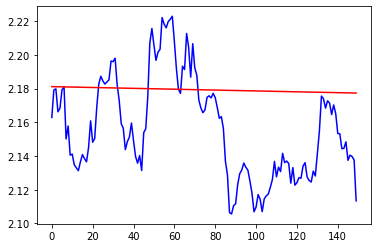

In [50]:
#a = np.exp(-1/45)         # correlation time is 45 sec
#std_w = 0.1/2.448*60*0.000164579      # consider NACp=7, i.e., 0.1   (for 2.448 see ADSB modeling paper)
        
        #..............target 1
        
#std_u = std_w
#u = np.random.normal(loc=0.0, scale=std_u)
#w_km1 = u
        
#vel_east_1_z[0] = x_t[3][0] + u
        
#for i_z in range(149):
            
#    std_u = std_w*np.sqrt(1-a**2)
#    u = np.random.normal(loc=0.0, scale=std_u)
#    w_k = a*w_km1 + u
            
#    vel_east_1_z[i_z+1] = x_t[3][i_z+1] + w_k
            
#    w_km1 = w_k


#=================
V_P = plt.subplot(111)
#=================    
#V_P.plot(x_t[0], x_t[1], '.b', label='Track_1')    
V_P.plot(east_1_z, 'b', label='Track_1')    
V_P.plot(east_1_t, 'r', label='Track_1')    


In [232]:
4038*13

52494

In [69]:
X_csv.shape

(150, 4382)

In [70]:
i_enc

336

In [18]:
y_c = (1>0)*1
h = 1

In [19]:
y_c

1

In [20]:
if y_c == 0:
    h = 0

In [21]:
h

1

In [234]:
YY_W = []
YY_c = []


#N_encounter_file = 12000

X_y = np.zeros(150)  #N_conf_enc))    # '150': it is the number of data points for each targets -- '13*N_encounter_file + 1': Number of all columns

i_enc_csv = -1

for i_enc in [8]:  #range(1):  #N_encounter_file):
    

    #============================== The following line convert a *.txt file with " " dilimter to the same file with "," dilimeter
# But the whole content is written in one column. The next cell below split this column to several column by splitting it 
# based on "," splitting.  /content/drive/My Drive/Colab Notebooks/Correlated-HALE/CSVFiles

    with open(arr[i_enc+6]) as infile, open('F:\SBIR-2020\RNN-Classification-Papers\DataSets\TEMP/out_truth_mit_ll_' + str(i_enc) + '.csv', 'w') as outfile:
         outfile.write(infile.read().replace(" ", ","))

    #------------------------------------

    df = pd.read_fwf('F:\SBIR-2020\RNN-Classification-Papers\DataSets\TEMP/out_truth_mit_ll_' + str(i_enc) + '.csv', header=None)  
    
    #df = pd.read_fwf('out_msg8001_half.csv', header=None)
    MITLL_Data_1 = df[0].str.split(',', expand=True)
    
    #------------------------------------ There is a space in the first column for time 1 sec to 9 sec. These lines take care of that.
    
    
    MITLL_Data = MITLL_Data_1.copy()

    for i in range(24):

        MITLL_Data[i][0:18] = MITLL_Data_1[i+1][0:18]

    #------------------------------------   
    
    BC_1 = MITLL_Data[1][0]
    BC_2 = MITLL_Data[1][1]

    
    lat_1 = MITLL_Data[MITLL_Data[1]==BC_1][3].astype(float).to_numpy()
    lat_2 = MITLL_Data[MITLL_Data[1]==BC_2][3].astype(float).to_numpy()

    lon_1 = MITLL_Data[MITLL_Data[1]==BC_1][4].astype(float).to_numpy()
    lon_2 = MITLL_Data[MITLL_Data[1]==BC_2][4].astype(float).to_numpy()
   
    alt_1 = MITLL_Data[MITLL_Data[1]==BC_1][5].astype(float).to_numpy()
    alt_2 = MITLL_Data[MITLL_Data[1]==BC_2][5].astype(float).to_numpy()

    vel_east_1t = MITLL_Data[MITLL_Data[1]==BC_1][7].astype(float).to_numpy()
    vel_east_2t = MITLL_Data[MITLL_Data[1]==BC_2][7].astype(float).to_numpy()

    vel_north_1t = MITLL_Data[MITLL_Data[1]==BC_1][8].astype(float).to_numpy()
    vel_north_2t = MITLL_Data[MITLL_Data[1]==BC_2][8].astype(float).to_numpy()

    vel_up_1t = MITLL_Data[MITLL_Data[1]==BC_1][9].astype(float).to_numpy()
    vel_up_2t = MITLL_Data[MITLL_Data[1]==BC_2][9].astype(float).to_numpy()


    #--------------------------------------------------------------Position conversion
    # The local coordinate origin 
    lat0 = np.array(0.6026) # deg
    lon0 = np.array(-2.05450)  # deg
    alt0 = np.array(0.2959)     # meters

    east_0, north_0, up_0 = pm.geodetic2enu(lat0/pi*180, lon0/pi*180, alt0*1852, lat0/pi*180, lon0/pi*180, alt0*1852)

    east_1, north_1, up_1 = pm.geodetic2enu(lat_1/pi*180, lon_1/pi*180, alt_1*1852, lat0/pi*180, lon0/pi*180, alt0*1852)
    east_2, north_2, up_2 = pm.geodetic2enu(lat_2/pi*180, lon_2/pi*180, alt_2*1852, lat0/pi*180, lon0/pi*180, alt0*1852)

    #--------------------------------------------------------------Velocity Conversion
    
    vel_east_1, vel_north_1, vel_up_1 = rotateEnuVelocity(vel_east_1t, vel_north_1t, vel_up_1t, lat_1, lon_1, lat0, lon0)
    vel_east_2, vel_north_2, vel_up_2 = rotateEnuVelocity(vel_east_2t, vel_north_2t, vel_up_2t, lat_2, lon_2, lat0, lon0)
    
    #--------------------------------------------------------------
    
    x = [east_1, north_1, up_1, vel_east_1, vel_north_1, vel_up_1, east_2, north_2, up_2, vel_east_2, vel_north_2, vel_up_2]
    
    #--------------------------------
    
    #------------------------------- Class
    
    x_t = np.array(x)
    
    #..........................
        
    #===========================================
    
    i_0 = 20
    
    Win_L = 20   # window length for sequence
    
    I_C = 0
    
    #..........................
    
    #......................... ONLY consider those encounter examples that have conflict 
    #if Yw_T[i_enc]==1:
        
        #...................
    
     #   i_enc_csv += 1  
    
        #...................
        
      #  for i_t in range(150):
        
        
       #      if i_t<Win_L-1:
        
       #           y = -1
            
       #      elif i_t>150-i_0-1:
        
       #           y = 3
            
       #      elif I_C == 1:
        
       #           y = 2
        
       #      else:
                          
                  #.............................
    
    H_dis = (np.sqrt((x_t[0][:] - x_t[6][:])**2 + (x_t[1][:] - x_t[7][:])**2)/1852<1)*1
    V_dis = (np.abs(x_t[2][:] - x_t[8][:])*3.28084<400)*1               
        
                  #............................
    
    Dis = H_dis*V_dis
    C_d = np.sum(Dis)
    
    y = (C_d>0)*1
             
                  #-------------
        
                  #if y==1:
                
                   #    I_C = 1
    
                  #...........................
    
             #X_y[i_t] =  np.array(y)


In [235]:
np.sum(y)

1

In [225]:
X_y

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.])

In [208]:
I_C

0

In [231]:
Yw_T[8]

1

In [216]:
i_enc_csv

0

In [217]:
i_t

149

In [232]:
Yw_TEMP = []


#N_encounter_file = 12000


for i_enc in [8]:  #range(N_encounter_file):

    #============================== The following line convert a *.txt file with " " dilimter to the same file with "," dilimeter
# But the whole content is written in one column. The next cell below split this column to several column by splitting it 
# based on "," splitting.  /content/drive/My Drive/Colab Notebooks/Correlated-HALE/CSVFiles

    with open(arr[i_enc+6]) as infile, open('F:\SBIR-2020\RNN-Classification-Papers\DataSets\TEMP/out_truth_mit_ll_' + str(i_enc) + '.csv', 'w') as outfile:
         outfile.write(infile.read().replace(" ", ","))

    #------------------------------------

    df = pd.read_fwf('F:\SBIR-2020\RNN-Classification-Papers\DataSets\TEMP/out_truth_mit_ll_' + str(i_enc) + '.csv', header=None)  
    
    #df = pd.read_fwf('out_msg8001_half.csv', header=None)
    MITLL_Data_1 = df[0].str.split(',', expand=True)
    
    #------------------------------------ There is a space in the first column for time 1 sec to 9 sec. These lines take care of that.
    
    
    MITLL_Data = MITLL_Data_1.copy()

    for i in range(24):

        MITLL_Data[i][0:18] = MITLL_Data_1[i+1][0:18]

    #------------------------------------   
    
    BC_1 = MITLL_Data[1][0]
    BC_2 = MITLL_Data[1][1]

    
    lat_1 = MITLL_Data[MITLL_Data[1]==BC_1][3].astype(float).to_numpy()
    lat_2 = MITLL_Data[MITLL_Data[1]==BC_2][3].astype(float).to_numpy()

    lon_1 = MITLL_Data[MITLL_Data[1]==BC_1][4].astype(float).to_numpy()
    lon_2 = MITLL_Data[MITLL_Data[1]==BC_2][4].astype(float).to_numpy()
   
    alt_1 = MITLL_Data[MITLL_Data[1]==BC_1][5].astype(float).to_numpy()
    alt_2 = MITLL_Data[MITLL_Data[1]==BC_2][5].astype(float).to_numpy()

    vel_east_1t = MITLL_Data[MITLL_Data[1]==BC_1][7].astype(float).to_numpy()
    vel_east_2t = MITLL_Data[MITLL_Data[1]==BC_2][7].astype(float).to_numpy()

    vel_north_1t = MITLL_Data[MITLL_Data[1]==BC_1][8].astype(float).to_numpy()
    vel_north_2t = MITLL_Data[MITLL_Data[1]==BC_2][8].astype(float).to_numpy()

    vel_up_1t = MITLL_Data[MITLL_Data[1]==BC_1][9].astype(float).to_numpy()
    vel_up_2t = MITLL_Data[MITLL_Data[1]==BC_2][9].astype(float).to_numpy()

    #---------------------------------------------------------
        
    
    #---------------------------------------------------------

    #--------------------------------------------------------------Position conversion
    # The local coordinate origin 
    lat0 = np.array(0.6026) # deg
    lon0 = np.array(-2.05450)  # deg
    alt0 = np.array(0.2959)     # meters

    east_0, north_0, up_0 = pm.geodetic2enu(lat0/pi*180, lon0/pi*180, alt0*1852, lat0/pi*180, lon0/pi*180, alt0*1852)

    east_1, north_1, up_1 = pm.geodetic2enu(lat_1/pi*180, lon_1/pi*180, alt_1*1852, lat0/pi*180, lon0/pi*180, alt0*1852)
    east_2, north_2, up_2 = pm.geodetic2enu(lat_2/pi*180, lon_2/pi*180, alt_2*1852, lat0/pi*180, lon0/pi*180, alt0*1852)

    #--------------------------------------------------------------Velocity Conversion
    
    vel_east_1, vel_north_1, vel_up_1 = rotateEnuVelocity(vel_east_1t, vel_north_1t, vel_up_1t, lat_1, lon_1, lat0, lon0)
    vel_east_2, vel_north_2, vel_up_2 = rotateEnuVelocity(vel_east_2t, vel_north_2t, vel_up_2t, lat_2, lon_2, lat0, lon0)
    
    #--------------------------------------------------------------
    
    x = [east_1, north_1, up_1, vel_east_1, vel_north_1, vel_up_1, east_2, north_2, up_2, vel_east_2, vel_north_2, vel_up_2]
    
    #X.append(x)

    #--------------------------------
    
    #--------------------------------
    
    #------------------------------- Class
    
    x_t = np.array(x)
    
    #..........................
    
    #=========================================== Check if there is a conflict
        
    H_dis_W = (np.sqrt((x_t[0][:] - x_t[6][:])**2 + (x_t[1][:] - x_t[7][:])**2)/1852<1)*1
    V_dis_W = (np.abs(x_t[2][:] - x_t[8][:])*3.28084<400)*1               
        
    #............................
    
    Dis_W = H_dis_W*V_dis_W
    C_d_W = np.sum(Dis_W)
    
    y_W = (C_d_W>0)*1
    
    Yw_TEMP.append(y_W)
        
Yw_T = np.array(Yw_TEMP)

In [233]:
Yw_TEMP

[1]

In [335]:

X = []
Y = []

N_encounter_file = 1

X_csv = np.zeros(shape=(150,13*N_encounter_file + 1))    # '150': it is the number of data points for each targets -- '13*N_encounter_file + 1': Number of all columns

for i_enc in [73]:  #range(N_encounter_file):

    #============================== The following line convert a *.txt file with " " dilimter to the same file with "," dilimeter
# But the whole content is written in one column. The next cell below split this column to several column by splitting it 
# based on "," splitting.  /content/drive/My Drive/Colab Notebooks/Correlated-HALE/CSVFiles

    with open(arr[i_enc+2]) as infile, open('F:\SBIR-2020\RNN-Classification-Papers\DataSets\TEMP/out_truth_mit_ll_' + str(i_enc) + '.csv', 'w') as outfile:
         outfile.write(infile.read().replace(" ", ","))

    #------------------------------------

    df = pd.read_fwf('F:\SBIR-2020\RNN-Classification-Papers\DataSets\TEMP/out_truth_mit_ll_' + str(i_enc) + '.csv', header=None)  
    
    #df = pd.read_fwf('out_msg8001_half.csv', header=None)
    MITLL_Data_1 = df[0].str.split(',', expand=True)
    
    #------------------------------------ There is a space in the first column for time 1 sec to 9 sec. These lines take care of that.
    
    
    MITLL_Data = MITLL_Data_1.copy()

    for i in range(24):

        MITLL_Data[i][0:18] = MITLL_Data_1[i+1][0:18]

    #------------------------------------   
    
    BC_1 = MITLL_Data[1][0]
    BC_2 = MITLL_Data[1][1]

    
    lat_1 = MITLL_Data[MITLL_Data[1]==BC_1][3].astype(float)
    lat_2 = MITLL_Data[MITLL_Data[1]==BC_2][3].astype(float)

    lon_1 = MITLL_Data[MITLL_Data[1]==BC_1][4].astype(float)
    lon_2 = MITLL_Data[MITLL_Data[1]==BC_2][4].astype(float)
   
    alt_1 = MITLL_Data[MITLL_Data[1]==BC_1][5].astype(float)
    alt_2 = MITLL_Data[MITLL_Data[1]==BC_2][5].astype(float)

    vel_east_1t = MITLL_Data[MITLL_Data[1]==BC_1][6].astype(float)
    vel_east_2t = MITLL_Data[MITLL_Data[1]==BC_2][7].astype(float)

    vel_north_1t = MITLL_Data[MITLL_Data[1]==BC_1][8].astype(float)
    vel_north_2t = MITLL_Data[MITLL_Data[1]==BC_2][8].astype(float)

    vel_up_1t = MITLL_Data[MITLL_Data[1]==BC_1][9].astype(float)
    vel_up_2t = MITLL_Data[MITLL_Data[1]==BC_2][9].astype(float)


    # The local coordinate origin 
    lat0 = np.array(0.6026) # deg
    lon0 = np.array(-2.05450)  # deg
    alt0 = np.array(0.2959)     # meters

    east_0, north_0, up_0 = pm.geodetic2enu(lat0/pi*180, lon0/pi*180, alt0*1852, lat0/pi*180, lon0/pi*180, alt0*1852)

    east_1t, north_1t, up_1t = pm.geodetic2enu(lat_1/pi*180, lon_1/pi*180, alt_1*1852, lat0/pi*180, lon0/pi*180, alt0*1852)
    east_2t, north_2t, up_2t = pm.geodetic2enu(lat_2/pi*180, lon_2/pi*180, alt_2*1852, lat0/pi*180, lon0/pi*180, alt0*1852)

    
    east_1 = east_1t.reset_index(drop=True)
    east_2 = east_2t.reset_index(drop=True)

    north_1 = north_1t.reset_index(drop=True)
    north_2 = north_2t.reset_index(drop=True)

    up_1 = up_1t.reset_index(drop=True)
    up_2 = up_2t.reset_index(drop=True)

    vel_east_1 = vel_east_1t.reset_index(drop=True)
    vel_east_2 = vel_east_2t.reset_index(drop=True)

    vel_north_1 = vel_north_1t.reset_index(drop=True)
    vel_north_2 = vel_north_2t.reset_index(drop=True)
 
    vel_up_1 = vel_up_1t.reset_index(drop=True)
    vel_up_2 = vel_up_2t.reset_index(drop=True)
    
    
    #east_1 = np.array(east_1ttt).reshape(1,len(east_1ttt))
    #east_2 = np.array(east_2ttt).reshape(1,len(east_2ttt))
    
    #north_1 = np.array(north_1ttt).reshape(1,len(north_1ttt))
    #north_2 = np.array(north_2ttt).reshape(1,len(north_2ttt))
    
    #up_1 = np.array(up_1ttt).reshape(1,len(up_1ttt))
    #up_2 = np.array(up_2ttt).reshape(1,len(up_2ttt))
    
    #vel_east_1 = np.array(vel_east_1ttt).reshape(1,len(vel_east_1ttt))
    #vel_east_2 = np.array(vel_east_2ttt).reshape(1,len(vel_east_2ttt))
    
    #vel_north_1 = np.array(vel_north_1ttt).reshape(1,len(vel_north_1ttt))
    #vel_north_2 = np.array(vel_north_2ttt).reshape(1,len(vel_north_2ttt))
    
    #vel_up_1 = np.array(vel_up_1ttt).reshape(1,len(vel_up_1ttt))
    #vel_up_2 = np.array(vel_up_2ttt).reshape(1,len(vel_up_2ttt))

    
    x = [east_1, north_1, up_1, vel_east_1, vel_north_1, vel_up_1, east_2, north_2, up_2, vel_east_2, vel_north_2, vel_up_2]
    
    X.append(x)

    
    #------------------------------- Class
    
    x_t = np.array(x)
    
    H_dis_v = (np.sqrt((x_t[0] - x_t[6])**2 + (x_t[1] - x_t[7])**2)/1852)
    V_dis_v = (np.abs(x_t[2] - x_t[8])*3.28084)
    
    H_dis = (np.sqrt((x_t[0] - x_t[6])**2 + (x_t[1] - x_t[7])**2)/1852<1)*1
    #V_dis = (np.abs(x_t[2] - x_t[8])*3.28084<400)*1
    V_dis = (np.abs(x_t[2] - x_t[8])*3.28084<400)*1
    
    #-------------------------------
    
    Dis = H_dis*V_dis
    C_d = np.sum(Dis)
    
    #C_d = np.sum(V_dis)
    #C_d = np.sum(H_dis)
    
    y = (C_d>0)*1
    
    Y.append(y)
    
    
    #-------------------------------

    #-----------------------------------------------Prepare np_array for CSV output

    y_array = np.ones(shape=(len(east_1),))*np.array(y)
    #x_array = x_t.reshape(-1,12)
    
    #X_csv[:,i_enc*13 + 1] =  x_t[0]/1852
    #X_csv[:,i_enc*13 + 2] =  x_t[1]/1852
    #X_csv[:,i_enc*13 + 3] =  x_t[2]/1852
    #X_csv[:,i_enc*13 + 4] =  x_t[3]
    #X_csv[:,i_enc*13 + 5] =  x_t[4]
    #X_csv[:,i_enc*13 + 6] =  x_t[5]
    #X_csv[:,i_enc*13 + 7] =  x_t[6]/1852
    #X_csv[:,i_enc*13 + 8] =  x_t[7]/1852
    #X_csv[:,i_enc*13 + 9] =  x_t[8]/1852
    #X_csv[:,i_enc*13 + 10] =  x_t[9]
    #X_csv[:,i_enc*13 + 11] =  x_t[10]
    #X_csv[:,i_enc*13 + 12] =  x_t[11]

    #X_csv[:,i_enc*13 + 13] =  y_array

    #-----------------------------------------------

time = MITLL_Data[MITLL_Data[1]==BC_1][0].astype(float)

X_csv[:,0] =  time
    
X = np.array(X)
Y = np.array(Y)



Data_Frame = pd.DataFrame(X_csv)
    
Data_Frame.to_csv('F:\SBIR-2020\RNN-Classification-Papers\DataSets/MITLL_Correlated_RNN_Data.csv')




In [336]:
Y

array([1])

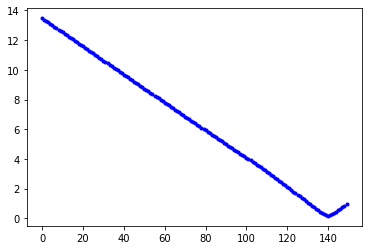

In [337]:
#=================
V_P = plt.subplot(111)
#=================    
V_P.plot(H_dis_v, '.b', label='Track_1')    


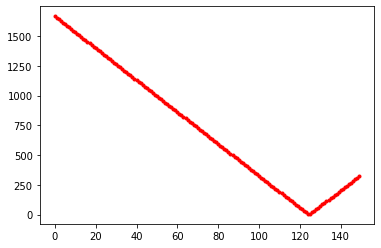

In [338]:
#=================
V_P = plt.subplot(111)
#=================    
V_P.plot(V_dis_v, '.r', label='Track_1')    


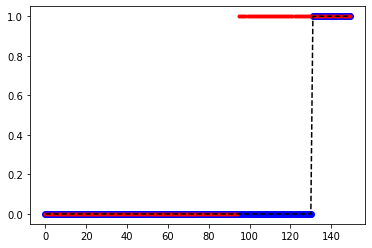

In [339]:
#=================
V_P = plt.subplot(111)
#=================    
V_P.plot(H_dis, 'ob', label='Track_1')    
V_P.plot(V_dis, '.r', label='Track_1')    
V_P.plot(Dis, '--k', label='Track_1')    

In [251]:
H_dis_v

array([8.27073668, 8.21290412, 8.15507894, 8.09726148, 8.03945155,
       7.98164983, 7.92385598, 7.86607003, 7.80829265, 7.75052394,
       7.6927641 , 7.63501309, 7.57727126, 7.51953933, 7.46181644,
       7.40410341, 7.34640069, 7.28870829, 7.23102622, 7.1733552 ,
       7.11569486, 7.05804636, 7.00040925, 6.9427839 , 6.8851711 ,
       6.827571  , 6.76998317, 6.71240869, 6.65484806, 6.59730115,
       6.53976849, 6.48225028, 6.42474717, 6.36725965, 6.30978765,
       6.25233242, 6.19489361, 6.13747216, 6.08006815, 6.02268243,
       5.96531526, 5.9079677 , 5.8506398 , 5.79333248, 5.73604588,
       5.67878138, 5.62153862, 5.56431938, 5.50712397, 5.44995247,
       5.39280665, 5.335687  , 5.2785941 , 5.22152909, 5.16449291,
       5.10748583, 5.05050988, 4.99356583, 4.93665471, 4.87977695,
       4.82293493, 4.76612935, 4.70936141, 4.65263273, 4.59594436,
       4.5392986 , 4.48269633, 4.42613961, 4.36962976, 4.31316908,
       4.25675942, 4.20040298, 4.1441011 , 4.08785713, 4.03167

In [252]:
V_dis_v

array([461.21160231, 461.08164427, 460.95168686, 460.82173015,
       460.69177225, 460.56181222, 460.43185507, 460.30189795,
       460.17193972, 460.04198328, 459.91202752, 459.78206883,
       459.6521126 , 459.52215437, 459.39219642, 459.26224093,
       459.1322842 , 459.00232343, 458.87236748, 458.74241088,
       458.61245272, 458.48249451, 458.35253817, 458.22258056,
       458.0926256 , 457.96266648, 457.83270861, 457.70275119,
       457.57279281, 457.44283617, 457.31287816, 457.18292148,
       457.05296464, 456.92300588, 456.79304901, 456.66309049,
       456.53313645, 456.40317772, 456.27322106, 456.14326293,
       456.01330443, 455.88334779, 455.75339206, 455.62343184,
       455.49347529, 455.36351833, 455.23356227, 455.1036041 ,
       454.97364608, 454.84368883, 454.71373073, 454.583774  ,
       454.45381782, 454.32385983, 454.19390261, 454.06394421,
       453.93398693, 453.8040286 , 453.67407226, 453.54411518,
       453.41415693, 453.28420065, 453.1542418 , 453.02

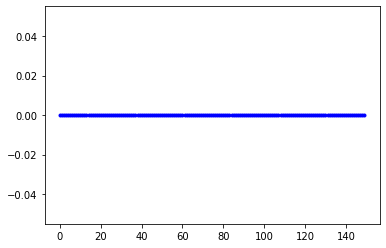

In [139]:
#=================
V_P = plt.subplot(111)
#=================    
V_P.plot(V_dis, '.b', label='Track_1')    


In [54]:
X.shape

(20, 150)

In [53]:
Data_Frame.head()

,0,1,2,3,4,5,6,7,8,9,...,121,122,123,124,125,126,127,128,129,130
0,1.0,-3.199313,-2.984004,0.124571,9.0,128.789091,-0.438327,3.081172,9.263206,0.021468,...,9.0,-19.721246,-0.212487,0.078437,9.342512,0.080187,59.326223,-177.011374,-0.394435,0.0
1,2.0,-3.157136,-2.948256,0.124520,9.0,128.787822,-0.435130,3.069469,9.216880,0.021508,...,9.0,-19.722421,-0.210749,0.094917,9.293342,0.080211,59.325639,-177.011576,-0.391616,0.0
2,3.0,-3.114959,-2.912508,0.124468,9.0,128.786552,-0.431932,3.057767,9.170555,0.021548,...,9.0,-19.723597,-0.209011,0.111397,9.244173,0.080235,59.325056,-177.011777,-0.388797,0.0
3,4.0,-3.072781,-2.876760,0.124417,9.0,128.785283,-0.428734,3.046065,9.124230,0.021587,...,9.0,-19.724773,-0.207273,0.127878,9.195003,0.080259,59.324472,-177.011979,-0.385977,0.0
4,5.0,-3.030603,-2.841012,0.124365,9.0,128.784013,-0.425537,3.034362,9.077905,0.021627,...,9.0,-19.725949,-0.205535,0.144358,9.145833,0.080283,59.323889,-177.012181,-0.383158,0.0


In [44]:
X.shape

(10, 2, 150)

In [43]:
Y[0]

0

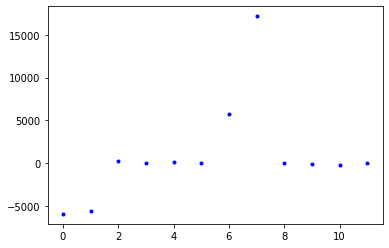

In [41]:
#=================
V_P = plt.subplot(111)
#=================    
V_P.plot(X[0,:,0], '.b', label='Track_1')    


In [125]:
np.sum(Y)

261

In [37]:
np.sum(H_dis)

20

In [38]:
np.sum(V_dis)

150

In [39]:
np.sum(Dis)

20

In [98]:
x_t[0].shape

(150,)

In [70]:
X = []
Y = []

N_encounter_file = 1

X_csv = np.zeros(shape=(150,13*N_encounter_file + 1))    # '150': it is the number of data points for each targets -- '13*N_encounter_file + 1': Number of all columns

for i_enc in [1]: #range(N_encounter_file):

    #============================== The following line convert a *.txt file with " " dilimter to the same file with "," dilimeter
# But the whole content is written in one column. The next cell below split this column to several column by splitting it 
# based on "," splitting.  /content/drive/My Drive/Colab Notebooks/Correlated-HALE/CSVFiles

    with open(arr[i_enc+2]) as infile, open('F:\SBIR-2020\RNN-Classification-Papers\DataSets\CorrelatedHale1Hz-(MITLL)\CorrelatedHale1Hz_TEMP/out_truth_mit_ll_' + str(i_enc) + '.csv', 'w') as outfile:
         outfile.write(infile.read().replace(" ", ","))

    #------------------------------------

    df = pd.read_fwf('F:\SBIR-2020\RNN-Classification-Papers\DataSets\CorrelatedHale1Hz-(MITLL)\CorrelatedHale1Hz_TEMP/out_truth_mit_ll_' + str(i_enc) + '.csv', header=None)  
    
    #df = pd.read_fwf('out_msg8001_half.csv', header=None)
    MITLL_Data = df[0].str.split(',', expand=True)
    
    #------------------------------------   
    
    BC_1 = MITLL_Data[1][0]
    BC_2 = MITLL_Data[1][1]

    
    lat_1 = MITLL_Data[MITLL_Data[1]==BC_1][3].astype(float)
    lat_2 = MITLL_Data[MITLL_Data[1]==BC_2][3].astype(float)

    lon_1 = MITLL_Data[MITLL_Data[1]==BC_1][4].astype(float)
    lon_2 = MITLL_Data[MITLL_Data[1]==BC_2][4].astype(float)
   
    alt_1 = MITLL_Data[MITLL_Data[1]==BC_1][5].astype(float)
    alt_2 = MITLL_Data[MITLL_Data[1]==BC_2][5].astype(float)

    vel_east_1t = MITLL_Data[MITLL_Data[1]==BC_1][7].astype(float)
    vel_east_2t = MITLL_Data[MITLL_Data[1]==BC_2][7].astype(float)

    vel_north_1t = MITLL_Data[MITLL_Data[1]==BC_1][8].astype(float)
    vel_north_2t = MITLL_Data[MITLL_Data[1]==BC_2][8].astype(float)

    vel_up_1t = MITLL_Data[MITLL_Data[1]==BC_1][9].astype(float)
    vel_up_2t = MITLL_Data[MITLL_Data[1]==BC_2][9].astype(float)


    # The local coordinate origin 
    lat0 = np.array(0.6026) # deg
    lon0 = np.array(-2.05450)  # deg
    alt0 = np.array(0.2959)     # meters

    east_0, north_0, up_0 = pm.geodetic2enu(lat0/pi*180, lon0/pi*180, alt0*1852, lat0/pi*180, lon0/pi*180, alt0*1852)

    east_1t, north_1t, up_1t = pm.geodetic2enu(lat_1/pi*180, lon_1/pi*180, alt_1*1852, lat0/pi*180, lon0/pi*180, alt0*1852)
    east_2t, north_2t, up_2t = pm.geodetic2enu(lat_2/pi*180, lon_2/pi*180, alt_2*1852, lat0/pi*180, lon0/pi*180, alt0*1852)

    
    east_1 = east_1t.reset_index(drop=True)
    east_2 = east_2t.reset_index(drop=True)

    north_1 = north_1t.reset_index(drop=True)
    north_2 = north_2t.reset_index(drop=True)

    up_1 = up_1t.reset_index(drop=True)
    up_2 = up_2t.reset_index(drop=True)

    vel_east_1 = vel_east_1t.reset_index(drop=True)
    vel_east_2 = vel_east_2t.reset_index(drop=True)

    vel_north_1 = vel_north_1t.reset_index(drop=True)
    vel_north_2 = vel_north_2t.reset_index(drop=True)
 
    vel_up_1 = vel_up_1t.reset_index(drop=True)
    vel_up_2 = vel_up_2t.reset_index(drop=True)
    
    
    #east_1 = np.array(east_1ttt).reshape(1,len(east_1ttt))
    #east_2 = np.array(east_2ttt).reshape(1,len(east_2ttt))
    
    #north_1 = np.array(north_1ttt).reshape(1,len(north_1ttt))
    #north_2 = np.array(north_2ttt).reshape(1,len(north_2ttt))
    
    #up_1 = np.array(up_1ttt).reshape(1,len(up_1ttt))
    #up_2 = np.array(up_2ttt).reshape(1,len(up_2ttt))
    
    #vel_east_1 = np.array(vel_east_1ttt).reshape(1,len(vel_east_1ttt))
    #vel_east_2 = np.array(vel_east_2ttt).reshape(1,len(vel_east_2ttt))
    
    #vel_north_1 = np.array(vel_north_1ttt).reshape(1,len(vel_north_1ttt))
    #vel_north_2 = np.array(vel_north_2ttt).reshape(1,len(vel_north_2ttt))
    
    #vel_up_1 = np.array(vel_up_1ttt).reshape(1,len(vel_up_1ttt))
    #vel_up_2 = np.array(vel_up_2ttt).reshape(1,len(vel_up_2ttt))

    
    
    
    x = [east_1, north_1, up_1, vel_east_1, vel_north_1, vel_up_1, east_2, north_2, up_2, vel_east_2, vel_north_2, vel_up_2]
    
    X.append(x)

    
    #------------------------------- Class
    
    x_t = np.array(x)
    
    H_dis_v = (np.sqrt((x_t[0] - x_t[6])**2 + (x_t[1] - x_t[7])**2)/1852)*1
    V_dis_v = (np.abs(x_t[2] - x_t[8])*3.28084)*1
    
    H_dis = (np.sqrt((x_t[0] - x_t[6])**2 + (x_t[1] - x_t[7])**2)/1852<1)*1
    V_dis = (np.abs(x_t[2] - x_t[8])*3.28084<400)*1
    
    Dis = H_dis*V_dis
    C_d = np.sum(Dis)
    
    y = (C_d>0)*1
    
    Y.append(y)
    
    
    #-------------------------------

    #-----------------------------------------------Prepare np_array for CSV output

    y_array = np.ones(shape=(len(east_1),))*np.array(y)
    #x_array = x_t.reshape(-1,12)
    
    X_csv[:, 1] =  x_t[0]/1852
    X_csv[:, 2] =  x_t[1]/1852
    X_csv[:, 3] =  x_t[2]/1852
    X_csv[:, 4] =  x_t[3]
    X_csv[:, 5] =  x_t[4]
    X_csv[:, 6] =  x_t[5]
    X_csv[:, 7] =  x_t[6]/1852
    X_csv[:, 8] =  x_t[7]/1852
    X_csv[:, 9] =  x_t[8]/1852
    X_csv[:, 10] =  x_t[9]
    X_csv[:, 11] =  x_t[10]
    X_csv[:, 12] =  x_t[11]

    X_csv[:, 13] =  y_array

    #-----------------------------------------------

time = MITLL_Data[MITLL_Data[1]==BC_1][0].astype(float)

X_csv[:,0] =  time
    
X = np.array(X)
Y = np.array(Y)




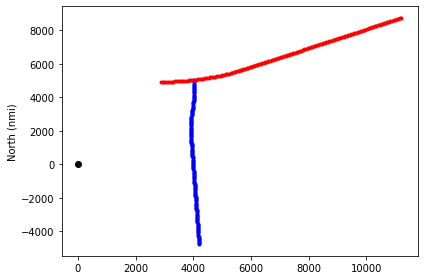

In [71]:
#=================

V_P = plt.subplot(111)

#=================
    
V_P.plot(east_0, north_0, 'ok', label='orign')
    
V_P.plot(east_1, north_1, '.b', label='Track_1') 
V_P.plot(east_2, north_2, '.r', label='Track_2')
    
    #plt.title('Tracks') #, fontsize=18)

    #plt.xlabel("East (nmi)") 
    
plt.ylabel("North (nmi)")  
plt.tight_layout()



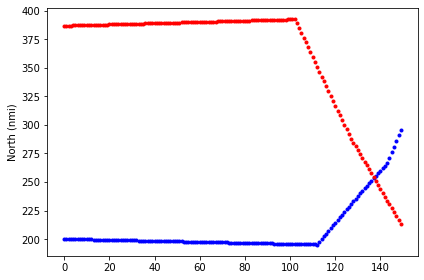

In [72]:
#=================

V_P = plt.subplot(111)

#=================
    
    
V_P.plot(up_1, '.b', label='Track_1') 
V_P.plot(up_2, '.r', label='Track_2')
    
    #plt.title('Tracks') #, fontsize=18)

    #plt.xlabel("East (nmi)") 
    
plt.ylabel("North (nmi)")  
plt.tight_layout()



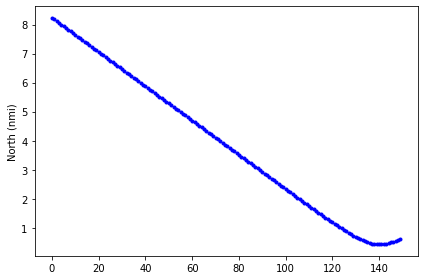

In [73]:
#=================

V_P = plt.subplot(111)

#=================
        
V_P.plot(H_dis_v, '.b', label='Track_1') 


    #plt.title('Tracks') #, fontsize=18)

    #plt.xlabel("East (nmi)") 
    
plt.ylabel("North (nmi)")  
plt.tight_layout()

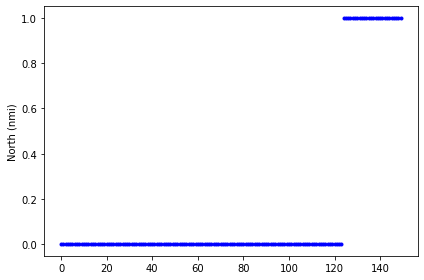

In [74]:
#=================

V_P = plt.subplot(111)

#=================
        
V_P.plot(H_dis, '.b', label='Track_1') 


    #plt.title('Tracks') #, fontsize=18)

    #plt.xlabel("East (nmi)") 
    
plt.ylabel("North (nmi)")  
plt.tight_layout()

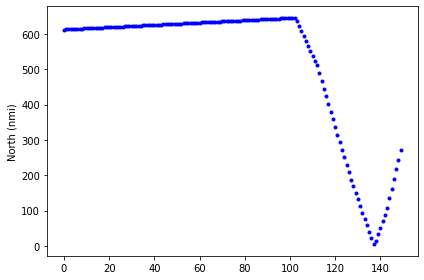

In [75]:
#=================

V_P = plt.subplot(111)

#=================
        
V_P.plot(V_dis_v, '.b', label='Track_1') 


    #plt.title('Tracks') #, fontsize=18)

    #plt.xlabel("East (nmi)") 
    
plt.ylabel("North (nmi)")  
plt.tight_layout()

In [76]:
np.amin(V_dis_v)

4.314313906589269

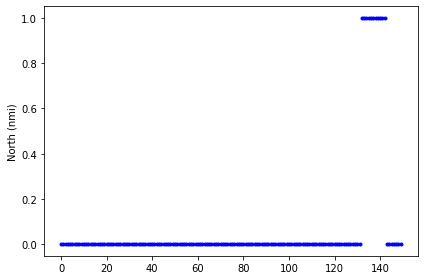

In [77]:
#=================

V_P = plt.subplot(111)

#=================
        
V_P.plot(V_dis, '.b', label='Track_1') 


    #plt.title('Tracks') #, fontsize=18)

    #plt.xlabel("East (nmi)") 
    
plt.ylabel("North (nmi)")  
plt.tight_layout()

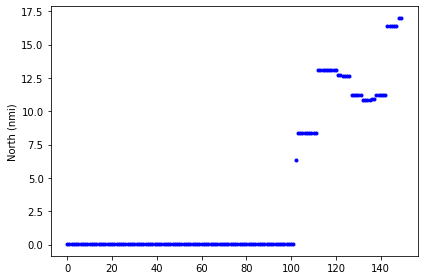

In [78]:
#=================

V_P = plt.subplot(111)

#=================
    
V_P.plot(np.abs(vel_up_1-vel_up_2), '.b', label='Track_1') 


    #plt.title('Tracks') #, fontsize=18)

    #plt.xlabel("East (nmi)") 
    
plt.ylabel("North (nmi)")  
plt.tight_layout()

In [63]:
a = 10*1852/3600
a

5.144444444444445

In [64]:
a*3

15.433333333333334

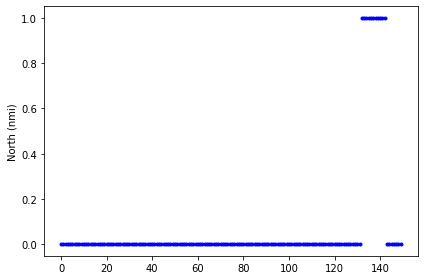

In [80]:
#=================

V_P = plt.subplot(111)

#=================
        
V_P.plot(Dis, '.b', label='Track_1') 


    #plt.title('Tracks') #, fontsize=18)

    #plt.xlabel("East (nmi)") 
    
plt.ylabel("North (nmi)")  
plt.tight_layout()

In [36]:
df.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,12991,12992,12993,12994,12995,12996,12997,12998,12999,13000
0,0,1.00,4201.571912,-4787.708852,200.208489,-2.852344,65.886909,-0.095653,11211.754660,8758.293086,...,0.0,71.948626,-4.007105,2857.013208,1611.587568,-459.096517,16.887986,24.016438,-0.013761,0.0
1,1,1.01,4201.543189,-4787.049681,200.208048,-2.852345,65.886909,-0.095646,11211.212590,8757.987295,...,0.0,71.948627,-4.007097,2857.182491,1611.827878,-459.096792,16.887986,24.016438,-0.013759,0.0
2,2,1.02,4201.514467,-4786.391145,200.207606,-2.852345,65.886909,-0.095639,11210.669994,8757.680868,...,0.0,71.948627,-4.007089,2857.351248,1612.068188,-459.097066,16.887987,24.016437,-0.013758,0.0
3,3,1.03,4201.485744,-4785.731974,200.207165,-2.852345,65.886909,-0.095632,11210.127924,8757.375078,...,0.0,71.948628,-4.007080,2857.520005,1612.308498,-459.097340,16.887987,24.016437,-0.013756,0.0
4,4,1.04,4201.457022,-4785.072803,200.206724,-2.852345,65.886909,-0.095625,11209.585854,8757.069287,...,0.0,71.948628,-4.007072,2857.688762,1612.548808,-459.097614,16.887988,24.016437,-0.013755,0.0


In [53]:
df['12987']

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
14896    1.0
14897    1.0
14898    1.0
14899    1.0
14900    1.0
Name: 12987, Length: 14901, dtype: float64

In [11]:
a =0

In [12]:
del a

In [13]:
a

NameError: name 'a' is not defined

In [14]:
a =1

In [15]:
a

1